# Alcohol Abuse Effects on EEG Data
## Neural Data Science Final Project

### Will Kersh​
### Dylan Cullifer​
### Isabell Cook

# Imports

In [ ]:
import pandas as pd
import numpy as np
import mne
import mne.viz
from mne.viz import plot_topomap
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.signal import hilbert
import os
from tqdm import tqdm
import statsmodels.api as sm
import sklearn
import seaborn as sns

# Path names
path_dir_train = 'eeg+database/SMNI_CMI_TRAIN/'
path_dir_test = 'eeg+database/SMNI_CMI_TEST/'

# one alcoholic patient and one control with same condition
alc_1 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
control_236 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data236.csv")

alc_1.head()

Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5             0             FP1           0        -8.921   
1           6             0             FP1           1        -8.433   
2           7             0             FP1           2        -2.574   
3           8             0             FP1           3         5.239   
4           9             0             FP1           4        11.587   

  subject identifier matching condition  channel         name      time  
0                  a             S1 obj        0  co2a0000364  0.000000  
1                  a             S1 obj        0  co2a0000364  0.003906  
2                  a             S1 obj        0  co2a0000364  0.007812  
3                  a             S1 obj        0  co2a0000364  0.011719  
4                  a             S1 obj        0  co2a0000364  0.015625

# Load data
This code enumerates over all of the training data files to load them in to our EEG_data object

In [42]:
file_names = [f for f in os.listdir('eeg+database/SMNI_CMI_TRAIN/') if f.endswith('.csv')]
EEG_data = pd.DataFrame({}) # create an empty data frame that will hold data from each file

for file_name in tqdm(file_names):
    temp_df = pd.read_csv('eeg+database/SMNI_CMI_TRAIN/' + file_name) # used to read each file into EEG_data
    EEG_data = pd.concat([EEG_data, temp_df], ignore_index=True)      # add the file data to the main data frame
    
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)                      # remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch' # remove comma from stimulus name

print(f"Loaded {len(file_names)} files")
print(f"Total rows: {len(EEG_data)}")
EEG_data.head()

100%|██████████| 468/468 [01:12<00:00,  6.47it/s]


Loaded 468 files
Total rows: 7667712


trial number sensor position  sample num  sensor value subject identifier  \
0             0             FP1           0        -8.921                  a   
1             0             FP1           1        -8.433                  a   
2             0             FP1           2        -2.574                  a   
3             0             FP1           3         5.239                  a   
4             0             FP1           4        11.587                  a   

  matching condition  channel         name      time  
0             S1 obj        0  co2a0000364  0.000000  
1             S1 obj        0  co2a0000364  0.003906  
2             S1 obj        0  co2a0000364  0.007812  
3             S1 obj        0  co2a0000364  0.011719  
4             S1 obj        0  co2a0000364  0.015625

In [43]:
control_236.head()

Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5             0             FP1           0         3.082   
1           6             0             FP1           1         2.594   
2           7             0             FP1           2         2.106   
3           8             0             FP1           3         2.106   
4           9             0             FP1           4         3.571   

  subject identifier matching condition  channel         name      time  
0                  c             S1 obj        0  co2c0000337  0.000000  
1                  c             S1 obj        0  co2c0000337  0.003906  
2                  c             S1 obj        0  co2c0000337  0.007812  
3                  c             S1 obj        0  co2c0000337  0.011719  
4                  c             S1 obj        0  co2c0000337  0.015625

### Some Pre-processing

Creating RawArray with float64 data, n_channels=61, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 32769 samples (128.004 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


C:\Users\dylan\AppData\Local\Temp\ipykernel_36816\1996821262.py:30: RuntimeWarning: filter_length (32769) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')
c:\Users\dylan\miniforge3\envs\networkScience\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


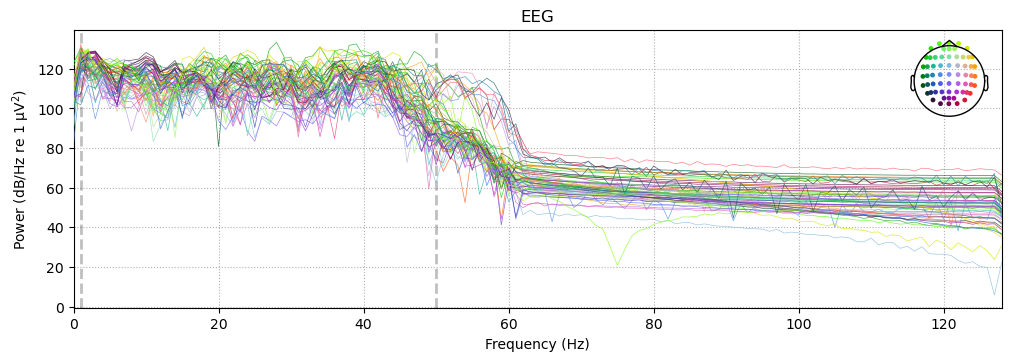

In [44]:

def csv_to_eeg_data(csv_file):
    data = pd.read_csv(csv_file)
    # Remove the positions that don't conform to the international 10-20 system.
    data = data.drop(data[data["sensor position"].isin(["X", "Y", "nd"])].index)

    # sensor placement names error out unless you fix them
    data["sensor position"] = data["sensor position"].replace({'FP1': 'Fp1', 'FP2': 'Fp2',
                                                               'FZ': 'Fz', 'CZ': 'Cz',
                                                               'PZ': 'Pz', 'FPZ': 'Fpz',
                                                               'AFZ': 'AFz', 'FCZ': 'FCz',
                                                               'POZ': 'POz', 'OZ': 'Oz',
                                                               'CPZ': 'CPz'})

    # get pos names
    sensor_pos = list(data["sensor position"].unique())
    # extract only needed eeg data
    subset = data[["channel", "sensor value", "sample num"]]
    # flip into channels x time 
    formatted = subset.pivot(index="channel", columns="sample num", values="sensor value").sort_index(axis=1)
    new_data = formatted.to_numpy()

    # convert to mne data and set channels
    channels_sfreq = mne.create_info(ch_names=sensor_pos, sfreq=256, ch_types="eeg")
    mne_data = mne.io.RawArray(new_data, channels_sfreq)

    mne_data.set_montage(mne.channels.make_standard_montage('standard_1020'))
    
    # Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
    # Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
    mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')

    return mne_data

alc_test = csv_to_eeg_data("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
alc_test.plot_psd()

# Load in all CSV Train and Test data into MNE Object and preprocess
Input from Dylan, Will, and Isabell

metadata: \
    &emsp;`trail`\
    &emsp;`group`: \
        &emsp;&emsp;`a` for alcohol\
        &emsp;&emsp;`c` for control\
    &emsp;`condition`: \
        &emsp;&emsp;'S1 obj'\
        &emsp;&emsp;'S2 match' \
        &emsp;&emsp;'S2 nomatch'\
    &emsp;`name`: subject's name

In [45]:
"""
    Read in all csvs in a directory and put them into mne.EpochsArray
    
    Input: 
        dir_path: directory path to where csv files are stored
        (Optional) sfreq: sample frequency
    Output:
        mne.EpochArray
"""
def read_csv_epoch(dir_path, sfreq=256.0):
    file_names = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
    # Define variables to use to create MNE
    datas_2d = []
    metas = []
    ch_names = None
    for f in tqdm(file_names):
        temp_df = pd.read_csv(dir_path + f)
        
        # Setup mne Matrix (channel, time)
        ## make key for this sample = time (time is the unique value)
        temp_df_time = temp_df.pivot(index='time', columns='sensor position', values='sensor value')
        ## convert to 2D numpy (time, channel)
        temp_2d = temp_df_time.to_numpy()
        ## Transpose to (channel, time)
        temp_2d = temp_2d.T
        
        # Save metadata from CSV into meta
        meta = {
            "trial": int(temp_df["trial number"].iloc[0]),
            "group": str(temp_df["subject identifier"].iloc[0]),   # 'a' or 'c' for 'alcohol' or 'control'
            "condition": str(temp_df["matching condition"].iloc[0]), # 'S1 obj', 'S2 match', or 'S2 nomatch'
            "name": str(temp_df["name"].iloc[0]),
        }
        
        # Check Channel names (Should be same for all trails)
        channels = list(temp_df_time.columns)
        if ch_names is None:
            ch_names = channels
        elif ch_names != channels: 
            print(f"{dir_path}{f} has different channels and was excluded.\n\tExpected: {ch_names}\n\tGot: {channels}")
            continue
        
        # Save data to use to create mne epoch array
        datas_2d.append(temp_2d)
        metas.append(meta)
        
    # Create 3D np array (epoch, channel, time)
    datas_3d = np.stack(datas_2d, axis=0)
    
    # Build mne info 
    ## Define type of channel - dataset has some channels that are not typical in eeg
    ch_names_filtered = ["misc" if c in ["X", "Y", "nd"] else "eeg" for c in ch_names]
    ## Create mne info object
    mne_info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_names_filtered)
    ## set montage to standard_1020
    mne_info.set_montage(mne.channels.make_standard_montage('standard_1020'), match_case=False, on_missing="ignore")
    
    # Convert metadata into a dataframe 
    metas_df = pd.DataFrame(metas)
    
    # Create events from "matching condition" in the dataset
    ## Grab unique conditions - should just be 'S1 obj', 'S2 match', or 'S2 nomatch'
    conditions = sorted(metas_df["condition"].unique())
    ## Map to an integer code
    event_ids = {cond: i+1 for i, cond in enumerate(conditions)}
    ## Map epochs to events
    event_codes = metas_df["condition"].map(event_ids).to_numpy()
    # Grab number of epochs
    n_epochs = datas_3d.shape[0]
    # Create events
    events = np.c_[np.arange(n_epochs), np.zeros(n_epochs, int), event_codes]
    
    # Create EpochsArray
    epochs = mne.EpochsArray(
        data=datas_3d,
        info=mne_info,
        events=events,
        event_id=event_ids,
        tmin=0.0,
        metadata=metas_df
    )
    
    # Print some verification statements
    print(f"CSV Files Found: {len(file_names)}")
    print(f"Epochs Loaded: {len(epochs)}")
    print(f"Number of files not loaded (missing data): {len(file_names) - len(epochs)}")
    print(f"Shape of epochs: {epochs.get_data().shape}")
    print(f"Metadata length matches epoch length: {len(epochs.metadata) == len(epochs)}")
    print(f"Number of Trials found:{epochs.metadata["trial"].nunique()}")
    print(f"Number of Subjects found: {epochs.metadata["name"].nunique()}")
    print(f"Conditions found: {epochs.metadata["condition"].unique()}")
    print(f"Groups found: {epochs.metadata["group"].unique()}")
    return epochs
        
# Read in Test and Train Data
print("Loading in Train Data")
epochs_train = read_csv_epoch(path_dir_train)
print("\nLoading in Test Data")
epochs_test = read_csv_epoch(path_dir_test)

# Merge the two via their metadata
## Concatenate teh epochs
epochs_merged = mne.concatenate_epochs([epochs_train, epochs_test])
## Drop duplicated metadata rows
unique_metadata = ~epochs_merged.metadata.duplicated()
## keep only epochs with unique data
epochs = epochs_merged[unique_metadata.to_numpy()]

# Sanity check prints
print(f"epochs_train shape: {epochs_train.get_data().shape}")
print(f"epochs_test shape: {epochs_test.get_data().shape}")
print(f"epochs shape: {epochs.get_data().shape}")

# Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
# Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
epochs.filter(l_freq=1.0, h_freq=50.0)
        

Loading in Train Data


100%|██████████| 468/468 [00:10<00:00, 46.30it/s]


Adding metadata with 4 columns
468 matching events found
No baseline correction applied
0 projection items activated
CSV Files Found: 468
Epochs Loaded: 468
Number of files not loaded (missing data): 0
Shape of epochs: (468, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:62
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']

Loading in Test Data


100%|██████████| 480/480 [00:09<00:00, 48.02it/s]

Adding metadata with 4 columns
480 matching events found
No baseline correction applied
0 projection items activated


CSV Files Found: 480
Epochs Loaded: 480
Number of files not loaded (missing data): 0
Shape of epochs: (480, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:66
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']
Adding metadata with 4 columns
948 matching events found
No baseline correction applied
epochs_train shape: (468, 64, 256)
epochs_test shape: (480, 64, 256)
epochs shape: (924, 64, 256)
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



C:\Users\dylan\AppData\Local\Temp\ipykernel_36816\3212785102.py:116: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=1.0, h_freq=50.0)


<EpochsArray | 924 events (all good), 0 – 0.996 s (baseline off), ~115.6 MiB, data loaded, with metadata,
 'S1 obj': 320
 'S2 match': 303
 'S2 nomatch,': 301>

### Separating epochs by important factors

In [46]:
"""
    Group the given mne.EpochArray into 3D dict of grouped mne.EpochArray
    
    Inputs:
        epochs: mne.EpochArray
        dim_1: name of attribute key for values stored in epochs. keys to the first dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the second dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the third dict in output
    Output: 2D dictionary storing mne.EpochArray
"""
def group_epochs_3D(epochs, dim_1, dim_2, dim_3):
    # Create a dict to store 3 nested dicts in:
    data = {}
    # Loop over all unique epochs of 1st dimension attribute
    for dim_1_id in tqdm(sorted(epochs.metadata[dim_1].unique())):
        # Trial is only one that is int
        dim_1_cond = f'{dim_1} == "{dim_1_id}"'
        if (dim_1 == "trial"):
            dim_1_id = int(dim_1_id)
            dim_1_cond = f'{dim_1} == {dim_1_id}'
        # Create item in data for given epoch
        data[dim_1_id] = {}
        # Loop over all unique epochs of 2nd dimension attribute
        epochs_dim_1 = epochs[dim_1_cond]
        for dim_2_id in epochs_dim_1.metadata[dim_2].unique():
            # Trial is only one that is int
            dim_2_cond = f'{dim_2} == "{dim_2_id}"'
            if (dim_2 == "trial"):
                dim_2_id = int(dim_2_id)
                dim_2_cond = f'{dim_2} == {dim_2_id}'
            # Create item in data for given 2 attributes
            data[dim_1_id][dim_2_id] = {}
            # Grab all epochs with the given 2 attributes
            epochs_dim_2 = epochs[f'{dim_1_cond} and {dim_2_cond}']
            # Loop over all unique epochs of 3rd dimension attribute
            for dim_3_id in epochs_dim_2.metadata[dim_3].unique():
                # Trial is only one that is int
                dim_3_cond = f'{dim_3} == "{dim_3_id}"'
                if (dim_3 == "trial"):
                    dim_3_id = int(dim_3_id)
                    dim_3_cond = f'{dim_3} == {dim_3_id}'
                epochs_dim_3 = epochs[f'{dim_1_cond} and {dim_2_cond} and {dim_3_cond}']
                # Store the given data for the 3 attribute values
                data[dim_1_id][dim_2_id][dim_3_id] = epochs_dim_3
    return data

"""
    Group the given mne.EpochArray into 2D dict of grouped mne.EpochArray
    
    Inputs:
        epochs: mne.EpochArray
        dim_1: name of attribute key for values stored in epochs. keys to the first dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the second dict in output
    Output: 2D dictionary storing mne.EpochArray
"""
def group_epochs_2D(epochs, dim_1, dim_2):
    # Create a dict to store 3 nested dicts in:
    data = {}
    # Loop over all unique epochs of 1st dimension attribute
    for dim_1_id in tqdm(sorted(epochs.metadata[dim_1].unique())):
        # Trial is only one that is int
        dim_1_cond = f'{dim_1} == "{dim_1_id}"'
        if (dim_1 == "trial"):
            dim_1_id = int(dim_1_id)
            dim_1_cond = f'{dim_1} == {dim_1_id}'
        # Create item in data for given epoch
        data[dim_1_id] = {}
        # Loop over all unique epochs of 2nd dimension attribute
        epochs_dim_1 = epochs[dim_1_cond]
        for dim_2_id in epochs_dim_1.metadata[dim_2].unique():
            # Trial is only one that is int
            dim_2_cond = f'{dim_2} == "{dim_2_id}"'
            if (dim_2 == "trial"):
                dim_2_id = int(dim_2_id)
                dim_2_cond = f'{dim_2} == {dim_2_id}'
            # Create item in data for given 2 attributes
            data[dim_1_id][dim_2_id] = {}
            # Grab all epochs with the given 2 attributes
            epochs_dim_2 = epochs[f'{dim_1_cond} and {dim_2_cond}']
            # Store the given data for the 3 attribute values
            data[dim_1_id][dim_2_id] = epochs_dim_2
    return data

# Group epochs into 3D dict subgroups trial -> condition -> group
epochs_trial_cond_group = group_epochs_3D(epochs, "trial", "condition", "group")
# Group epochs into 3D dict subgroups condition -> group -> name
epochs_cond_group_subject = group_epochs_3D(epochs, "condition", "group", "name")
# Group epochs into 2D dict subgroups condition -> group
epochs_cond_group = group_epochs_2D(epochs, "condition", "group")


100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


# Format Data

## 2D dict mne.EpochArray to 2D dict mne.evoked

(epoch, channel, time) -> (avg_channel, time)

In [47]:
"""
    Convert from dict of EpochArray to dict of evoked (Average of epoch array) 
        2D Dict of (event, channel, time) to 2D Dict of (channel, time)
    
    Input: 2 Dimensional Dictionary of mne.EpochsArray
    Output: 2 Dimensional Dictionary of mne.Evoked
"""
def convert_2D_grouping(epochs):
    # Initialize new dict
    evoked_data = {}
    # Loop over all epochs
    for key, subdict in epochs.items():
        # Initialize dict for given key
        evoked_data[key] = {}
        # Loop over 2nd dimension dictionary
        for sub_key, epoch_array in subdict.items():
            evoked_data[key][sub_key] = epoch_array.average()
    return evoked_data
            
# Convert epochs_cond_group from 2D dict mne.EpochArray to 2D dict mne.evoked
avg_cond_group = convert_2D_grouping(epochs_cond_group)

## MNE 2D dict (channel, time) -> 2D dict (region, time)

In [48]:
regions = {
    'Fp': ['FP1', 'FP2', 'FPZ'],                             # Prefrontal
    'F': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FZ', 
          'AF1', 'AF2', 'AF7', 'AF8', 'AFZ'],                # Frontal
    'T': ['T7', 'T8', 'FT7', 'FT8', 'TP7', 'TP8'],           # Temporal
    'C': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CZ', 
          'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ',
          'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ'],  # Central
    'P': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PZ',
          'PO1', 'PO2', 'PO7', 'PO8', 'POZ'],                # Parietal
    'O': ['O1', 'O2', 'OZ']                                  # Occipital
}

"""
    Convert from dict of evoked (Average of epoch array) in channels (62 channels) to 2D dict of evoked in regions
            2D dict of (channel, time) to 2D dict of (region, time)
    
    Input: mne.Evoked (channel, time)
    Output: mne.EvokedArray (region, time)
"""
def convert_chan_to_region(evoked):
      # Grab channel names
      ch_names = evoked.ch_names
      # Grab sample frequency
      sfreq = evoked.info['sfreq']
      # Grab time sequence
      times = evoked.times
      # Define region variable for obj data
      region_data = []
      region_names = []
      # loop over region 
      for name, channels in regions.items():
            # Select corresponding channels from evoked
            chns = mne.pick_channels(ch_names, include=channels, ordered=False)
            # Catch and skip loop if no channel exists
            if len(chns) == 0:
                  continue
            # Average the selected channels
            reg_ts = evoked.data[chns].mean(axis=0)
            # Append name and time_series data to variables
            region_data.append(reg_ts)
            region_names.append(name)

      # Create new mne info for object for region
      info = mne.create_info(ch_names=region_names, sfreq=sfreq, ch_types='eeg')
      # Create evokedArray object of regions
      region_evoked = mne.EvokedArray(region_data, info, tmin=times[0])
      return region_evoked

"""
    Convert from dict of evoked (Average of epoch array) in channels (62 channels) to 2D dict of evoked in regions
            2D dict of (channel, time) to 2D dict of (region, time)
    
    Input: 2 Dimensional Dictionary of mne.Evoked in (channel, time) shape 
    Output: 2 Dimensional Dictionary of mne.Evoked in (region, time) shape
"""
def convert_2d_avg_to_region(avg_epochs):
      region_data = {}
      for key, subdict in avg_epochs.items():
            region_data[key] = {}
            for sub_key, arr in subdict.items():
                  region_data[key][sub_key] = convert_chan_to_region(arr)
                  print(region_data[key][sub_key].data.shape)      # (n_regions, n_times)
                  print(region_data[key][sub_key].ch_names)
      return region_data
                  
reg_cond_group = convert_2d_avg_to_region(avg_cond_group)

(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']


# Base Visualizations

In [49]:
# Define time array for all plots
times = np.arange(0,1,0.1)

## Plot Individual Evoked Groupings
Condition, group Topomap and time_series of each channel

C:\Users\dylan\AppData\Local\Temp\ipykernel_36816\998447034.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_ts.tight_layout()


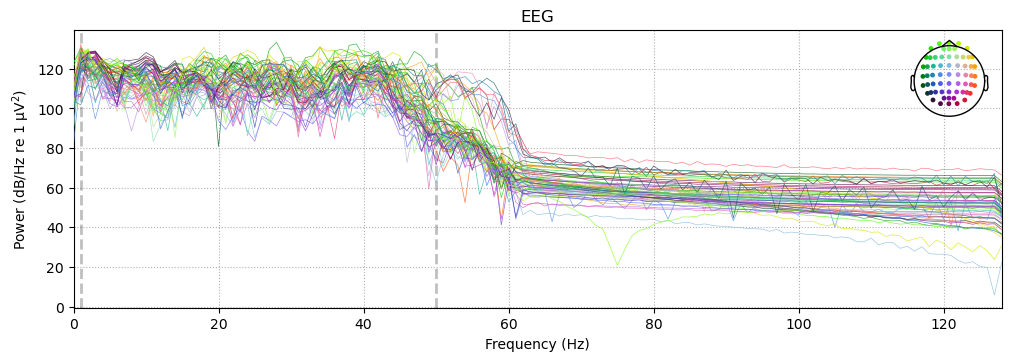

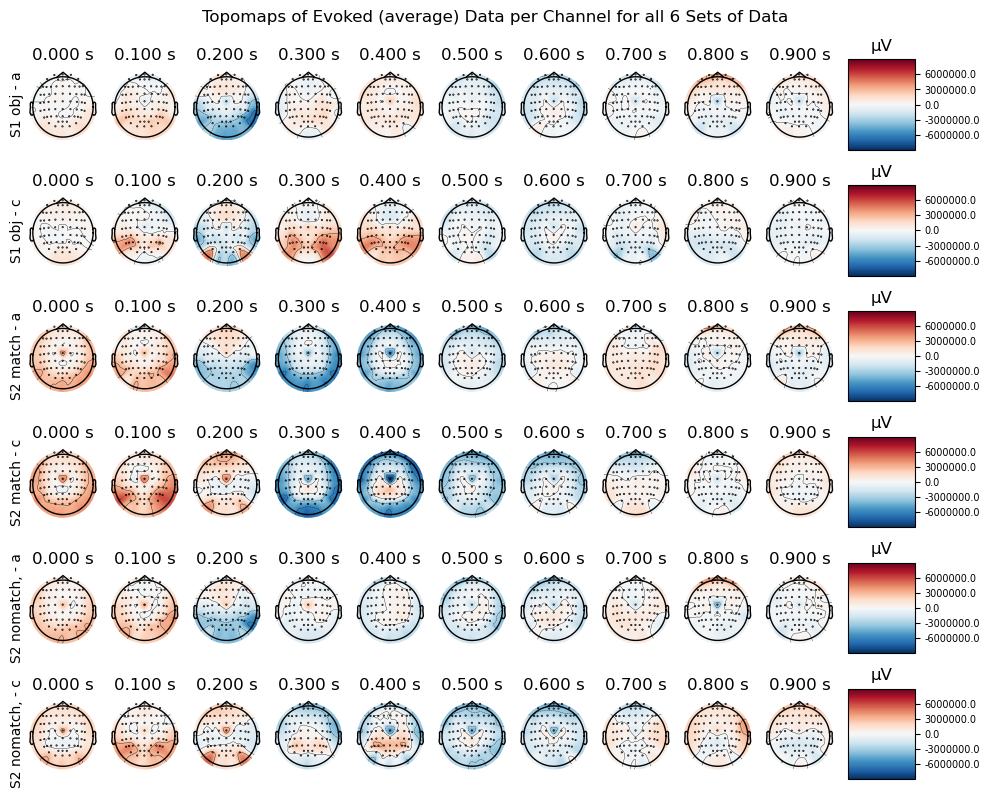

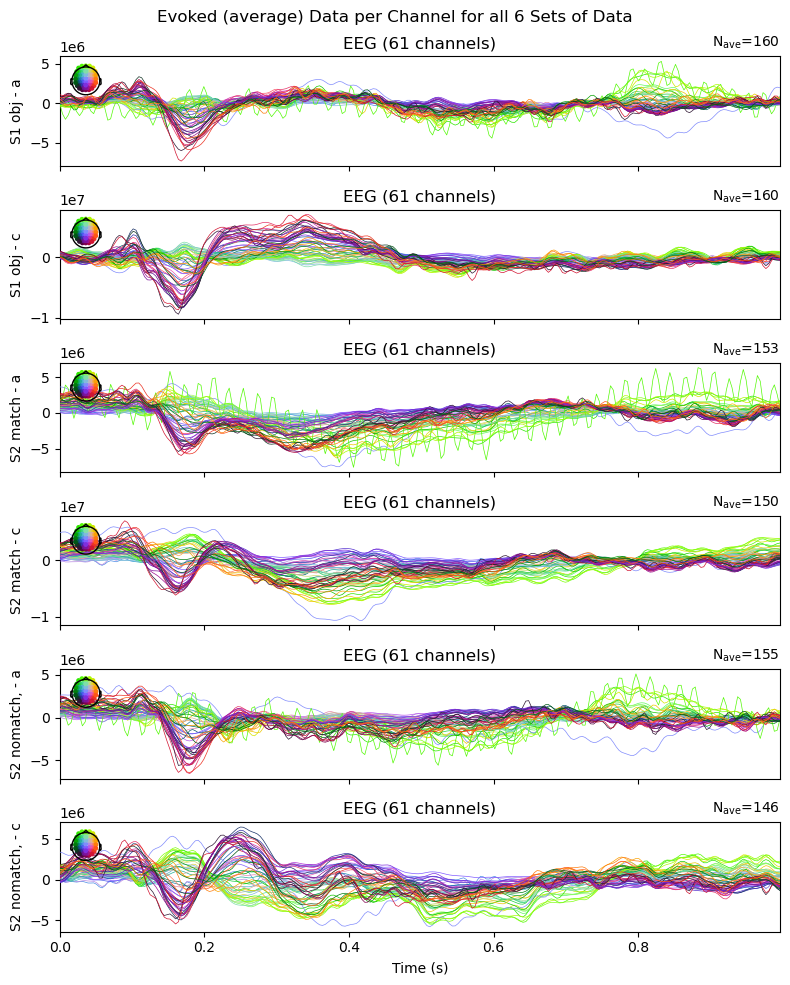

In [50]:
# Define figures for showing topomaps and time_series in one plot
fig_topo, axes_topo = plt.subplots(6, len(times)+1, figsize=(10,8))
fig_ts, axes_ts = plt.subplots(6, 1, figsize=(8,10))
# Set standard min/max for topomap colorbar
vmin, vmax = -9e6, 9e6
# Variable to control axes
a = 0
# Loop over outer dict
for key, evoked_objs in avg_cond_group.items():
    # Loop over inner dict
    for sub_key, evoked in evoked_objs.items():
        # Plot topomap
        evoked.plot_topomap(times, ch_type='eeg', axes=axes_topo[a], show=False, vlim=(vmin, vmax))
        # Set sub labels
        axes_topo[a, 0].set_ylabel(f"{key} - {sub_key}")
        # Plot time series data per channel
        mne.viz.plot_evoked(evoked, axes=axes_ts[a], show=False, spatial_colors=True, picks="eeg")
        # Set sub labels
        axes_ts[a].set_ylabel(f"{key} - {sub_key}")
        # Remove x axis label besides the last imgs
        if a != 5:
            axes_ts[a].set_xticklabels([])
            axes_ts[a].set_xlabel("")
        a+=1
fig_topo.suptitle(f"Topomaps of Evoked (average) Data per Channel for all 6 Sets of Data")
fig_ts.suptitle(f"Evoked (average) Data per Channel for all 6 Sets of Data")
fig_topo.tight_layout()
fig_ts.tight_layout()
plt.show()

## Plot Comparing Conditions

### Evoked GFP Time_Series

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


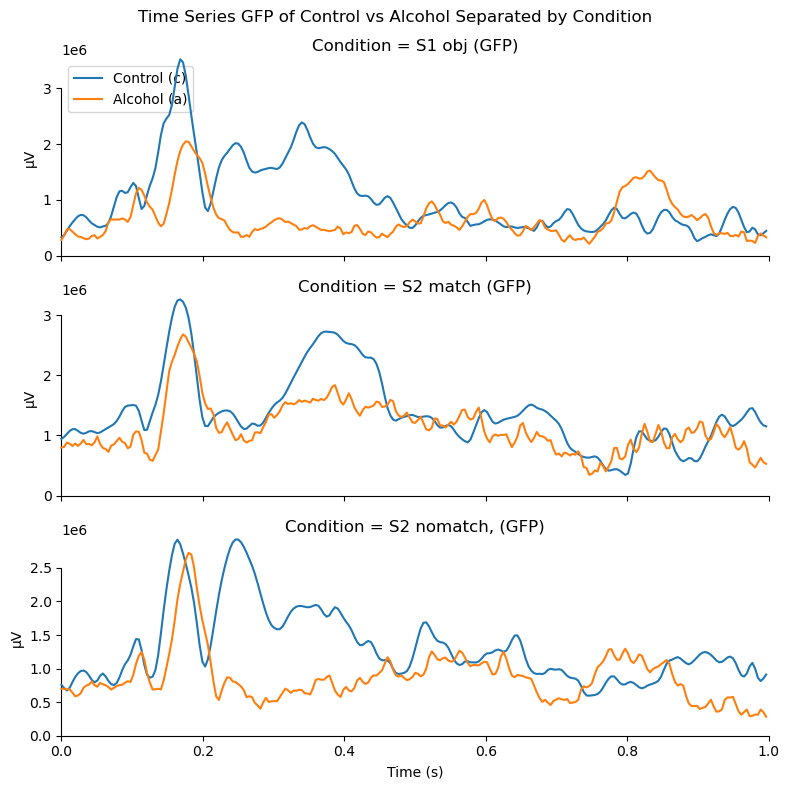

In [51]:
# Define figures for showing topomaps and time_series in one plot
fig, axes = plt.subplots(3, 1, figsize=(8,8))
# Loop over outer dict
for i, (key, evoked_objs) in enumerate(avg_cond_group.items()):
    # Generate time_series comparison plot compare control vs alcohol
    fig_cmp = mne.viz.plot_compare_evokeds({ "Control (c)": evoked_objs["c"], "Alcohol (a)": evoked_objs["a"]}, show=False, title=f"Condition = {key}", axes=axes[i])
    # Remove legends besides the 1st imgs
    if i != 0:
        axes[i].get_legend().remove()
    # Remove x axis label besides the last imgs
    if i != 2:
        axes[i].set_xticklabels([])
        axes[i].set_xlabel("")
fig.suptitle(f"Time Series GFP of Control vs Alcohol Separated by Condition")
fig.tight_layout()
plt.show()

### Evoked Topomap Differences

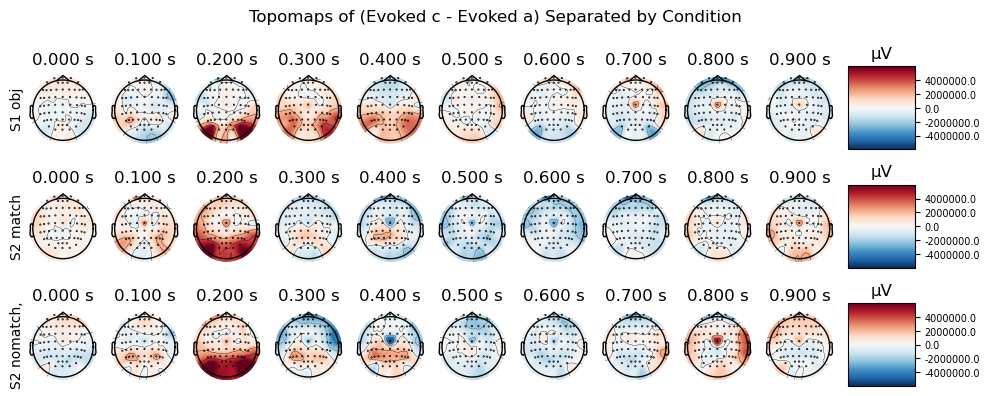

In [52]:
# Define figures for showing topomaps and time_series in one plot
fig, axes = plt.subplots(3, len(times)+1, figsize=(10,4))
# Set standard min/max for topomap colorbar
vmin, vmax = -6e6, 6e6
# Variable to control axes
a = 0
# Loop over outer dict
for a, (key, evoked_objs) in enumerate(avg_cond_group.items()):
    # Use mne to calculate difference (control - alcohol)
    evoked_diff = mne.combine_evoked([evoked_objs['c'], evoked_objs['a']], weights=[1, -1])
    # Plot topomap of difference
    evoked_diff.plot_topomap(times, ch_type='eeg', axes=axes[a], show=False, vlim=(vmin, vmax))
    # Set y label
    axes[a, 0].set_ylabel(f"{key}")
fig.suptitle(f"Topomaps of (Evoked c - Evoked a) Separated by Condition")
fig.tight_layout()
plt.show()

### Evoked Region Differences

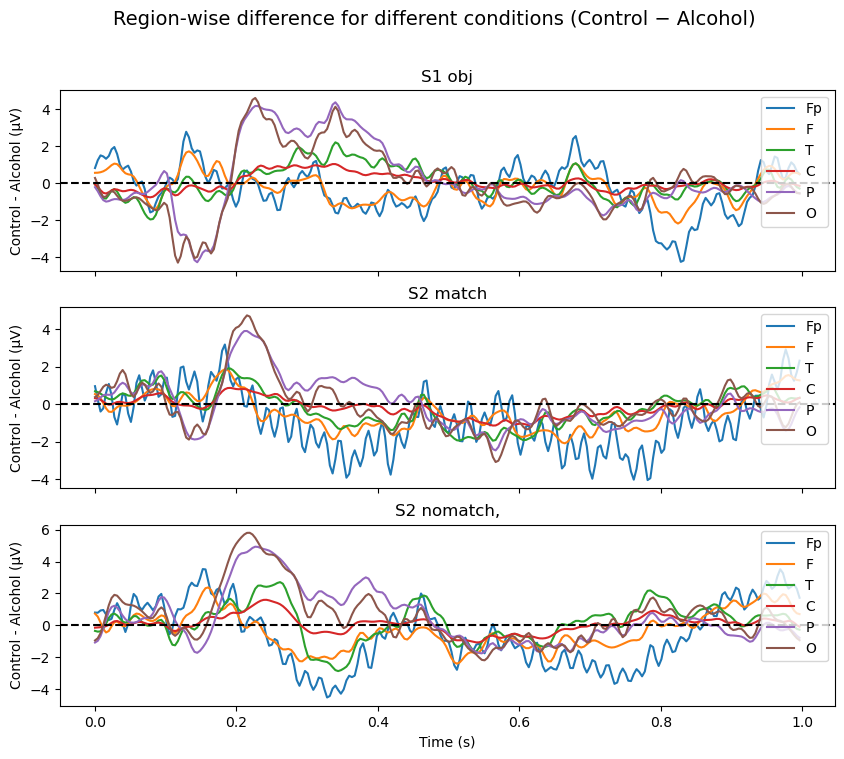

In [53]:
# Create figure with 3 row subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
# Loop over outer dict of region evoked data
for a, (key, evoked_objs) in enumerate(reg_cond_group.items()):
    # Calculate difference between regional control - alcohol data
    diff = mne.combine_evoked([evoked_objs['c'], evoked_objs['a']], weights=[1, -1])
    # select axes
    ax = axes[a]
    # Plot difference for each region (ch_names)
    for i, reg in enumerate(diff.ch_names):
        ax.plot(diff.times, diff.data[i], label=reg)
    # Configure plot
    ## Add black dotted line at 0 for simple comparison
    ax.axhline(0, color='k', linestyle='--')
    ## label the y axis
    ax.set_ylabel("Control - Alcohol (µV)")
    ## Give subplot a title
    ax.set_title(key)
    # Add legend in same spot for all subgraphs
    ax.legend(loc="upper right")
# Label only the x axis
axes[-1].set_xlabel("Time (s)")
# Add whole figure title
fig.suptitle("Region-wise difference for different conditions (Control − Alcohol)", fontsize=14)
plt.show()

## Regional Analysis: Alcoholic vs Control

In [54]:
# Get all unique electrode positions from the data
all_electrodes = EEG_data['sensor position'].unique()
print(f"All electrode positions: {sorted(all_electrodes)}\n")

# Define brain regions based on international 10-20 system's region names
regions = {
    'Fp': ['FP1', 'FP2', 'FPZ'],                             # Prefrontal
    'F': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FZ', 
          'AF1', 'AF2', 'AF7', 'AF8', 'AFZ'],                # Frontal
    'T': ['T7', 'T8', 'FT7', 'FT8', 'TP7', 'TP8'],           # Temporal
    'C': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CZ', 
          'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ',
          'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ'],  # Central
    'P': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PZ',
          'PO1', 'PO2', 'PO7', 'PO8', 'POZ'],                # Parietal
    'O': ['O1', 'O2', 'OZ']                                  # Occipital
}

All electrode positions: ['AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ', 'O1', 'O2', 'OZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1', 'PO2', 'PO7', 'PO8', 'POZ', 'PZ', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y', 'nd']



In [55]:
# Calculate regional means for all alcoholic and control subjects
# Using the pre-loaded EEG_data from NDS_Project.ipynb
alcoholic_regional = {region: [] for region in regions.keys()}
control_regional = {region: [] for region in regions.keys()}

# Group by subject name to process each subject's data
for subject_name in tqdm(EEG_data['name'].unique()):
    # Get all data for this subject
    subject_data = EEG_data[EEG_data['name'] == subject_name]
    
    # Get subject type (alcoholic = 'a', control = 'c')
    subject_type = subject_data['subject identifier'].iloc[0]
    
    # Calculate regional means for each region
    for region_name, channels in regions.items():
        # Filter data for channels in this region
        region_data = subject_data[subject_data['sensor position'].isin(channels)]
        
        if len(region_data) > 0:
            # Calculate mean sensor value across all channels in the region for each time point
            regional_mean = region_data.groupby('sample num')['sensor value'].mean().values
            
            # Store in appropriate group
            if subject_type == 'a':
                alcoholic_regional[region_name].append(regional_mean)
            else:
                control_regional[region_name].append(regional_mean)

# Convert to arrays and calculate means across subjects
alcoholic_means = {region: np.mean(np.array(data), axis=0) for region, data in alcoholic_regional.items()}
control_means = {region: np.mean(np.array(data), axis=0) for region, data in control_regional.items()}

# Calculate differences (Alcoholic - Control)
regional_differences = {region: alcoholic_means[region] - control_means[region] 
                        for region in regions.keys()}


100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


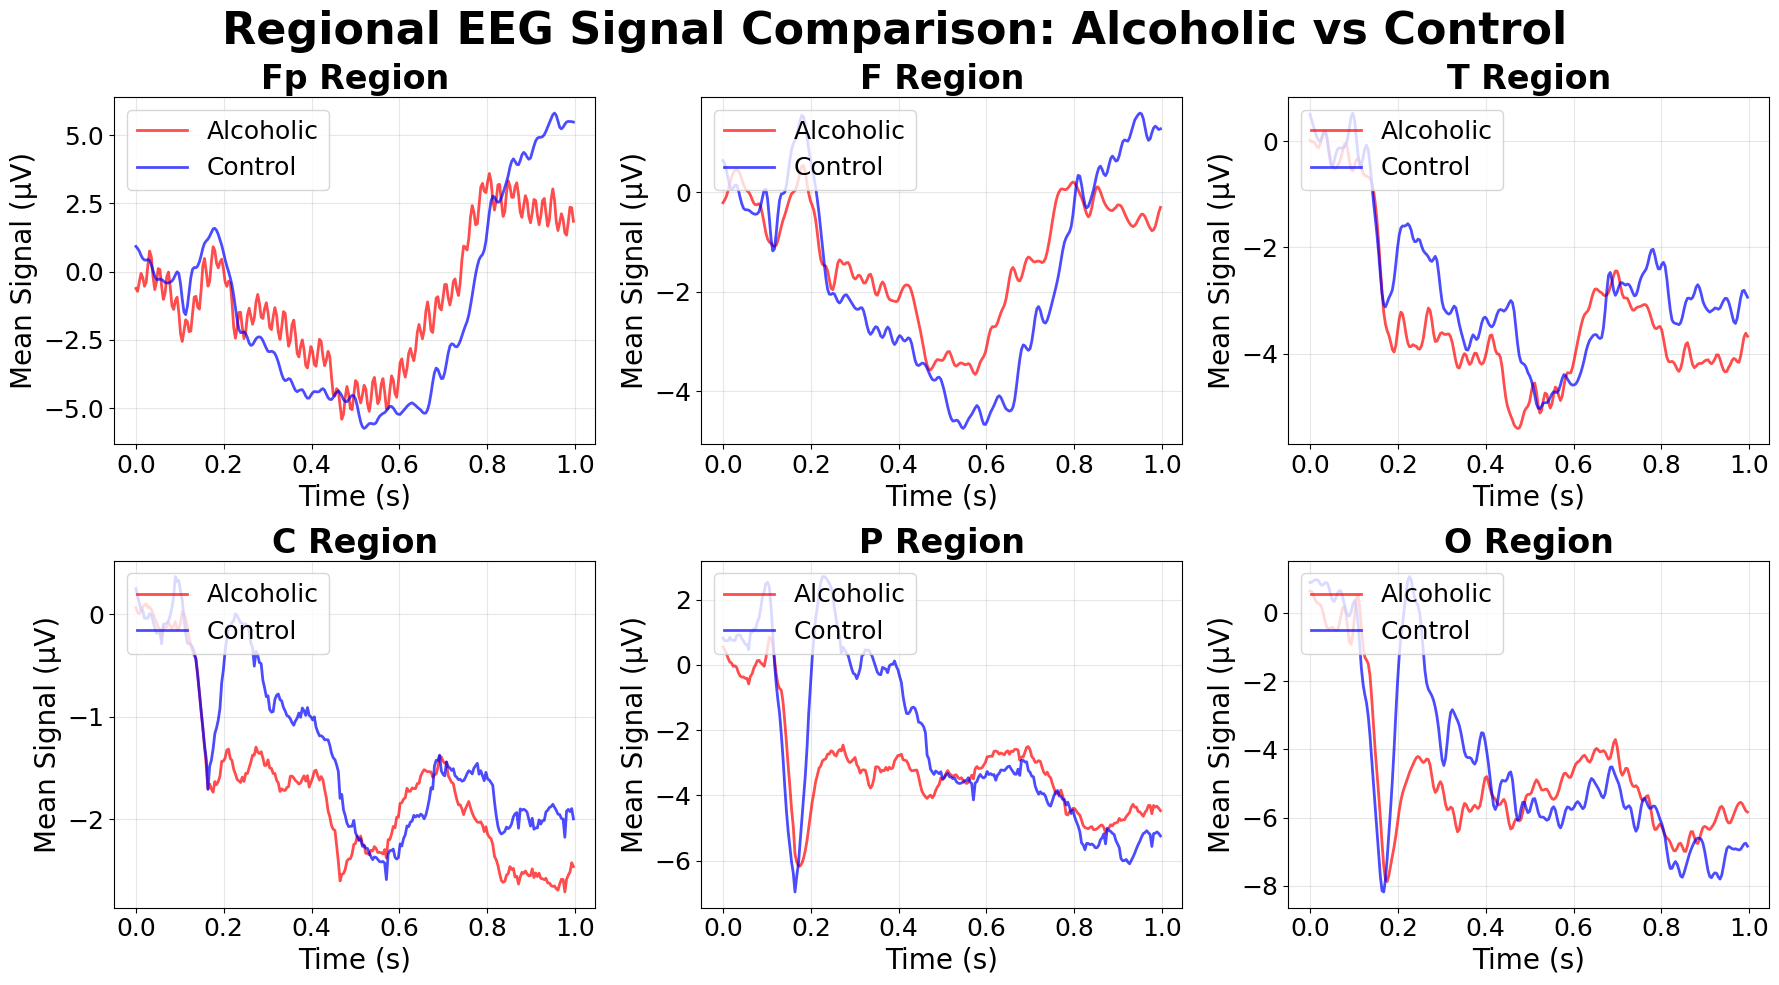


Regional Signal Differences (Mean, Std):
Fp Region:  +0.276 µV, Std:  1.751 µV
F  Region:  +0.303 µV, Std:  1.076 µV
T  Region:  -0.600 µV, Std:  0.715 µV
C  Region:  -0.370 µV, Std:  0.443 µV
P  Region:  -0.765 µV, Std:  1.825 µV
O  Region:  -0.259 µV, Std:  1.674 µV


In [56]:
# Visualize the differences between alcoholic and control groups
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

time_points = np.arange(256) / 256  # Frequency to time points  conversion

for idx, (region, diff) in enumerate(regional_differences.items()):
    ax = axes[idx]
    
    # Plot alcoholic mean
    ax.plot(time_points, alcoholic_means[region], label='Alcoholic', color='red', alpha=0.7, linewidth=2)
    
    # Plot control mean
    ax.plot(time_points, control_means[region], label='Control', color='blue', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time (s)', fontsize=20)
    ax.set_ylabel('Mean Signal (µV)', fontsize=20)
    ax.set_title(f'{region} Region', fontsize=24, fontweight='bold')
    ax.legend(loc='upper left', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, alpha=0.3)

plt.suptitle('Regional EEG Signal Comparison: Alcoholic vs Control', fontsize=32, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print("\nRegional Signal Differences (Mean, Std):")
for region in regions.keys():
    mean_diff = np.mean(regional_differences[region])
    std_diff = np.std(regional_differences[region])
    print(f"{region:2s} Region: {mean_diff:+7.3f} µV, Std: {std_diff:6.3f} µV") # Fancy formatting!

## Regional Analysis by Condition
Now let's create separate plots for each condition

In [57]:
# Function to calculate regional means for a specific condition
def process_condition_from_eeg_data(condition_name, regions):
    alcoholic_regional = {region: [] for region in regions.keys()}
    control_regional = {region: [] for region in regions.keys()}
    
    # Filter EEG_data for this specific condition
    condition_data = EEG_data[EEG_data['matching condition'] == condition_name]
    
    # Group by subject name to process each subject's data
    for subject_name in tqdm(condition_data['name'].unique(), desc=f"Processing {condition_name}"):
        # Get all data for this subject and condition
        subject_data = condition_data[condition_data['name'] == subject_name]
        
        # Get subject type (alcoholic = 'a', control = 'c')
        subject_type = subject_data['subject identifier'].iloc[0]
        
        # Calculate regional means for each region
        for region_name, channels in regions.items():
            # Filter data for channels in this region
            region_data = subject_data[subject_data['sensor position'].isin(channels)]
            
            if len(region_data) > 0:
                # Calculate mean sensor value across all channels in the region for each time point
                regional_mean = region_data.groupby('sample num')['sensor value'].mean().values
                
                # Store in appropriate group
                if subject_type == 'a':
                    alcoholic_regional[region_name].append(regional_mean)
                else:
                    control_regional[region_name].append(regional_mean)
    
    # Convert to arrays and calculate means across subjects
    alcoholic_means = {region: np.mean(np.array(data), axis=0) if len(data) > 0 else None 
                       for region, data in alcoholic_regional.items()}
    control_means = {region: np.mean(np.array(data), axis=0) if len(data) > 0 else None 
                     for region, data in control_regional.items()}
    
    return alcoholic_means, control_means, len(alcoholic_regional['Fp']), len(control_regional['Fp'])


In [58]:
# Get unique conditions from the data
unique_conditions = EEG_data['matching condition'].unique()

# We'll create plots for the 3 conditions
conditions_to_plot = sorted(unique_conditions)[:3]
condition_results = {}

for condition in conditions_to_plot:
    alc_means, ctrl_means, alc_count, ctrl_count = process_condition_from_eeg_data(condition, regions)
    condition_results[condition] = {
        'alcoholic_means': alc_means,
        'control_means': ctrl_means,
        'alcoholic_count': alc_count,
        'control_count': ctrl_count
    }
    print(f"\n{condition}: {alc_count} alcoholic subjects, {ctrl_count} control subjects")


Processing S1 obj: 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]



S1 obj: 8 alcoholic subjects, 8 control subjects


Processing S2 match: 100%|██████████| 16/16 [00:03<00:00,  4.93it/s]



S2 match: 8 alcoholic subjects, 8 control subjects


Processing S2 nomatch: 100%|██████████| 16/16 [00:03<00:00,  5.20it/s]



S2 nomatch: 8 alcoholic subjects, 8 control subjects


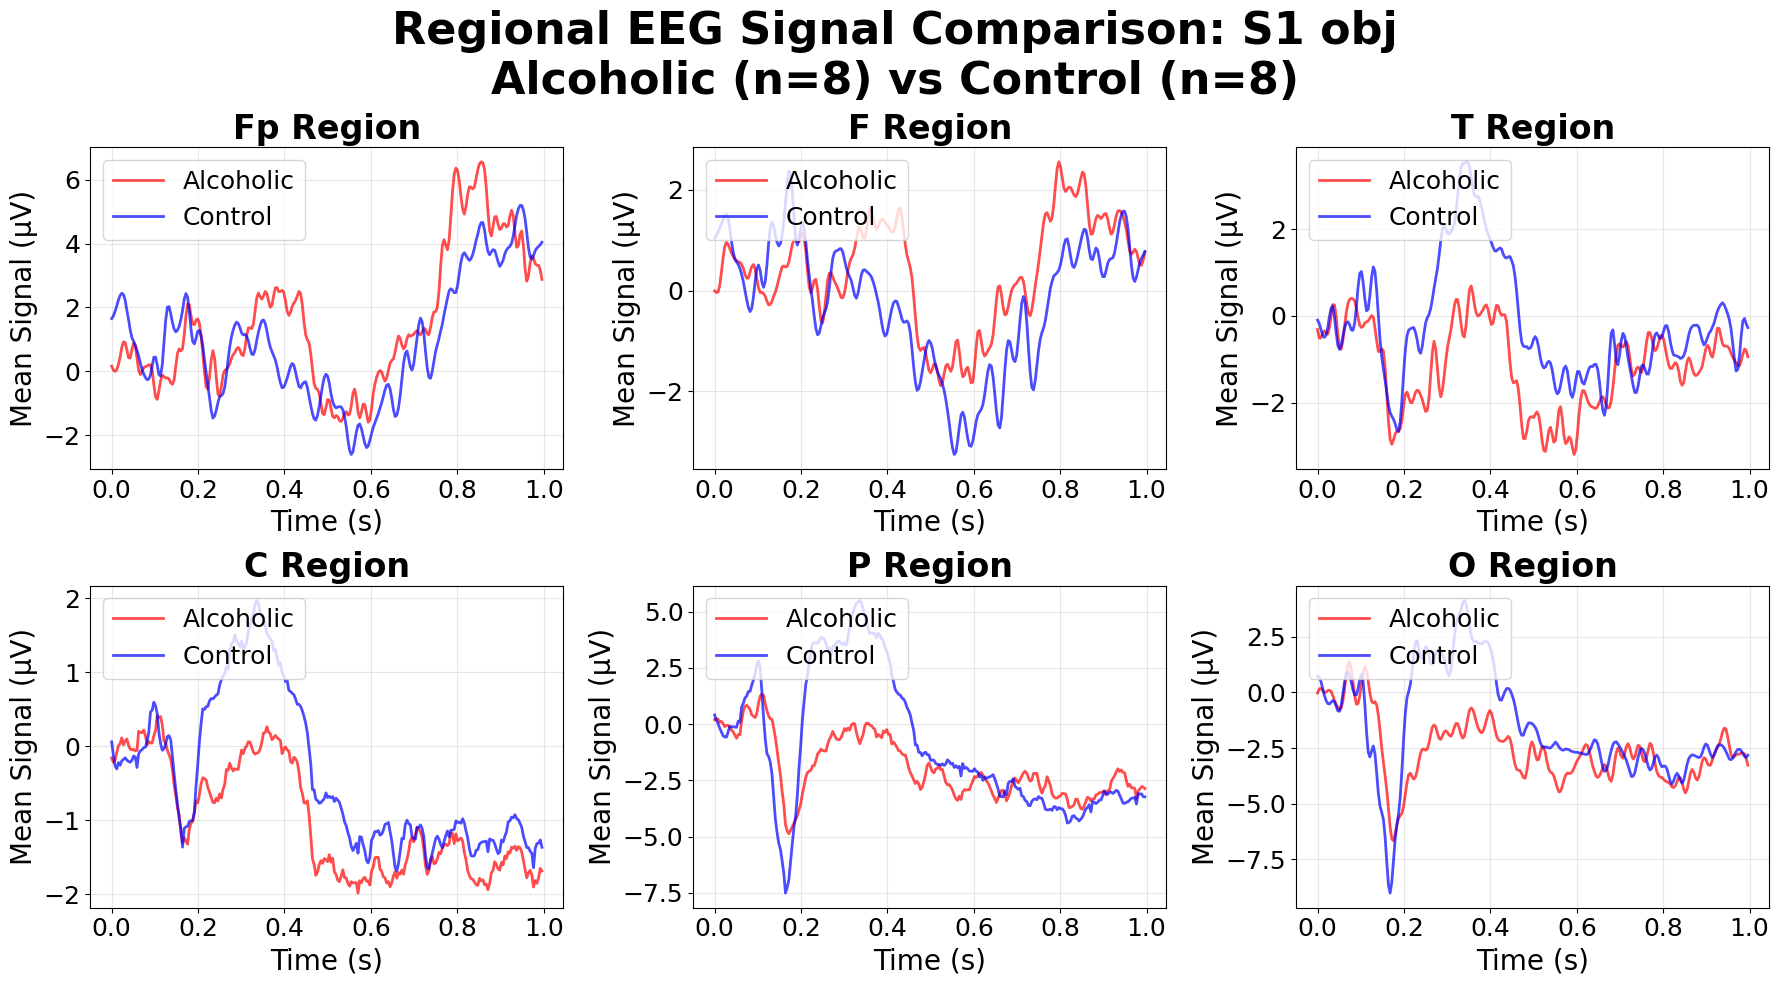


S1 obj: Regional Signal Differences (Mean, Std):
Fp Region:  +0.552 µV, Std:  1.255 µV
F  Region:  +0.609 µV, Std:  0.939 µV
T  Region:  -0.962 µV, Std:  0.997 µV
C  Region:  -0.566 µV, Std:  0.545 µV
P  Region:  -0.924 µV, Std:  2.171 µV
O  Region:  -1.029 µV, Std:  1.932 µV


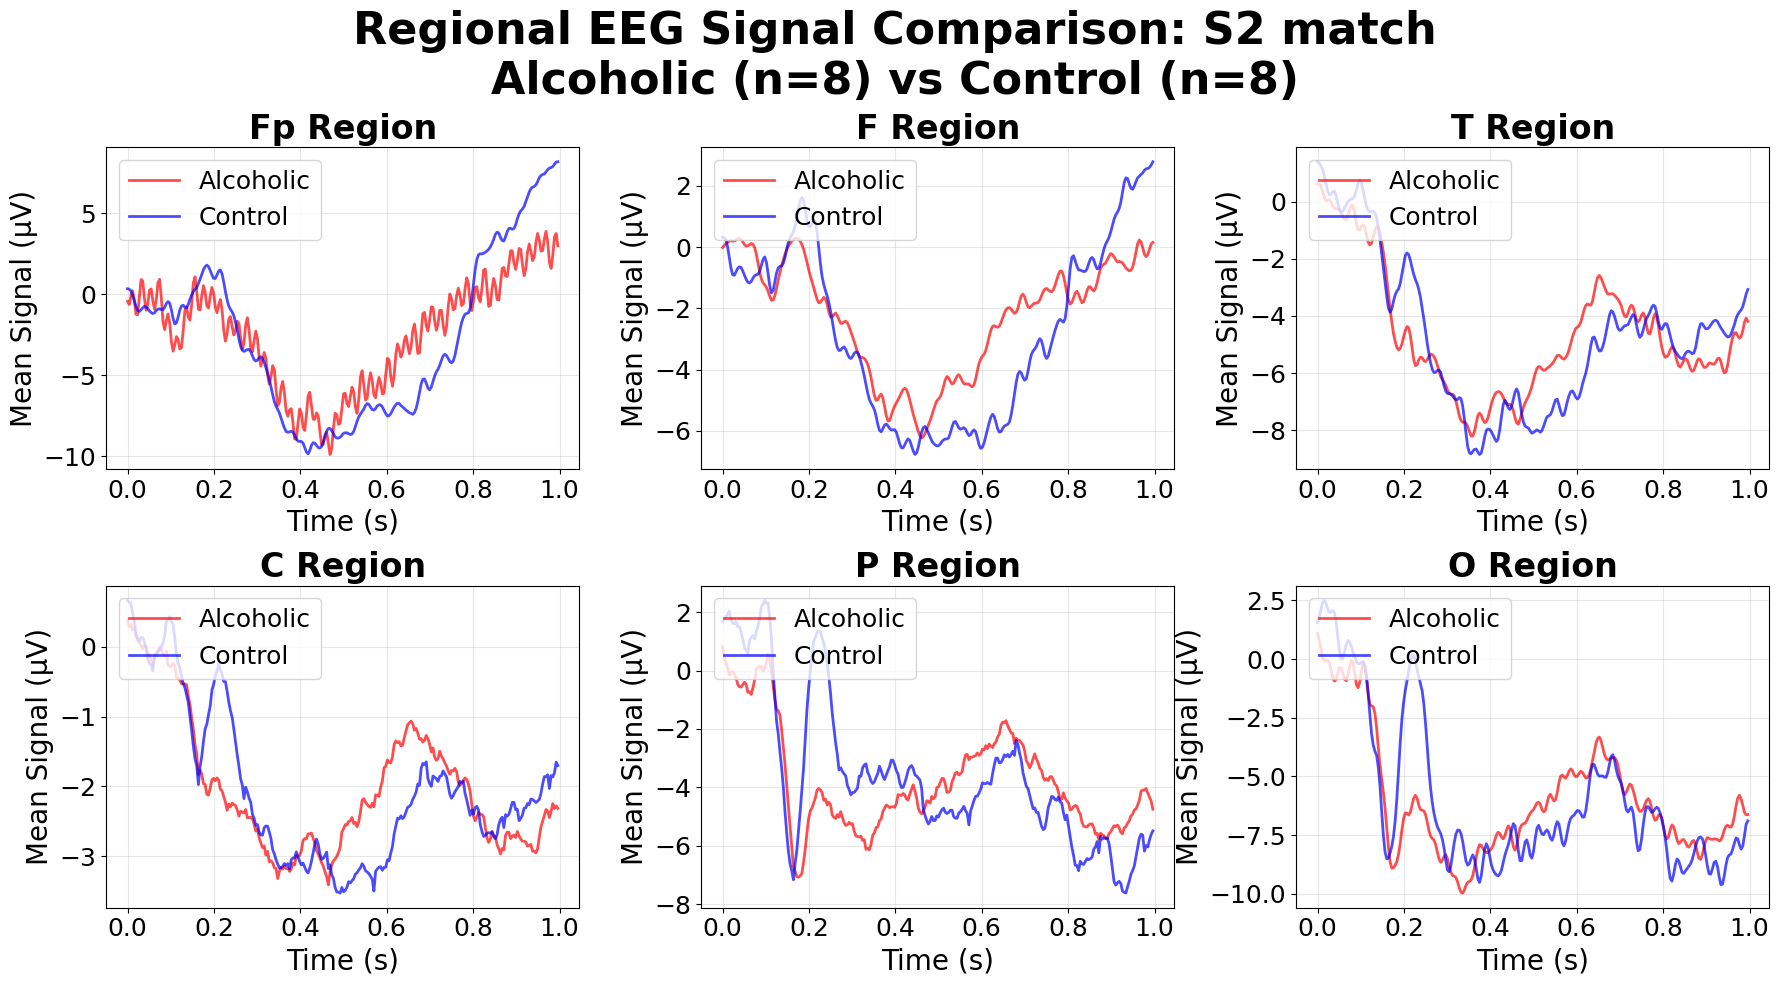


S2 match: Regional Signal Differences (Mean, Std):
Fp Region:  +0.180 µV, Std:  2.405 µV
F  Region:  +0.463 µV, Std:  1.553 µV
T  Region:  +0.035 µV, Std:  1.255 µV
C  Region:  +0.021 µV, Std:  0.659 µV
P  Region:  -0.197 µV, Std:  1.860 µV
O  Region:  +0.012 µV, Std:  1.887 µV


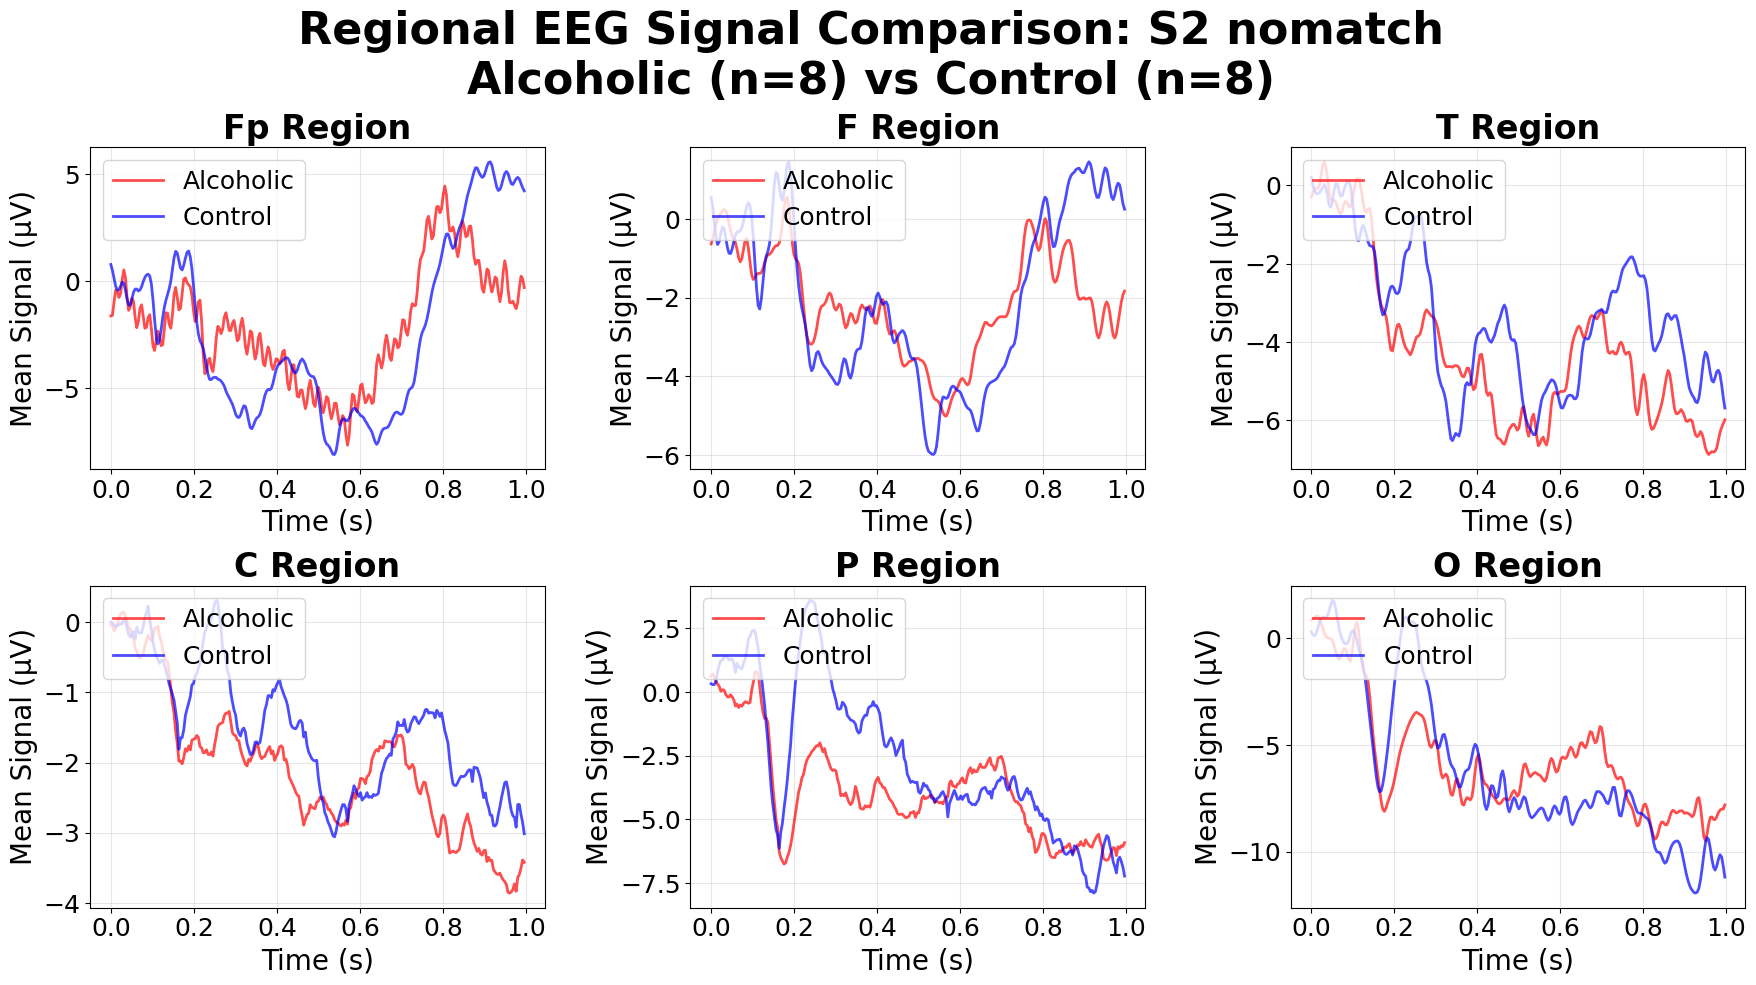


S2 nomatch: Regional Signal Differences (Mean, Std):
Fp Region:  +0.206 µV, Std:  2.715 µV
F  Region:  -0.141 µV, Std:  1.513 µV
T  Region:  -0.830 µV, Std:  1.336 µV
C  Region:  -0.546 µV, Std:  0.597 µV
P  Region:  -1.175 µV, Std:  1.916 µV
O  Region:  +0.298 µV, Std:  2.074 µV


In [59]:
# Create individual plots for each condition
time_points = np.arange(256) / 256

for condition in conditions_to_plot:
    result = condition_results[condition]
    alc_means = result['alcoholic_means']
    ctrl_means = result['control_means']
    
    # Create subplot for this condition
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, region in enumerate(regions.keys()):
        ax = axes[idx]
        
        # Plot alcoholic mean
        ax.plot(time_points, alc_means[region], label='Alcoholic', 
                color='red', alpha=0.7, linewidth=2)
        
        # Plot control mean
        ax.plot(time_points, ctrl_means[region], label='Control', 
                color='blue', alpha=0.7, linewidth=2)
        
        ax.set_xlabel('Time (s)', fontsize=20)
        ax.set_ylabel('Mean Signal (µV)', fontsize=20)
        ax.set_title(f'{region} Region', fontsize=24, fontweight='bold')
        ax.legend(loc='upper left', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Regional EEG Signal Comparison: {condition}\n'
                 f'Alcoholic (n={result["alcoholic_count"]}) vs Control (n={result["control_count"]})', 
                 fontsize=32, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this condition
    print(f"\n{condition}: Regional Signal Differences (Mean, Std):")
    for region in regions.keys():
        diff = alc_means[region] - ctrl_means[region]
        mean_diff = np.mean(diff)
        std_diff = np.std(diff)
        print(f"{region:2s} Region: {mean_diff:+7.3f} µV, Std: {std_diff:6.3f} µV")

### Wilcoxon Signed-Rank Test Function By Region


In [60]:
from scipy.stats import wilcoxon

# Function to use the Wilcoxon signed-rank test on our dataset
# Compares mean regional signals at each time point (paired by time)
def do_wilcoxon_test(condition, region_channels):
    # Calculate mean signal at each time point for alcoholic group
    alc_data = EEG_data[
        (EEG_data['subject identifier'] == 'a') & 
        (EEG_data['matching condition'] == condition) & 
        (EEG_data['sensor position'].isin(region_channels))
    ]
    
    # Calculate mean signal at each time point for control group
    ctrl_data = EEG_data[
        (EEG_data['subject identifier'] == 'c') & 
        (EEG_data['matching condition'] == condition) & 
        (EEG_data['sensor position'].isin(region_channels))
    ]
    
    if len(alc_data) > 0 and len(ctrl_data) > 0:
        # Group by time point and calculate mean for each group
        alc_means = alc_data.groupby('sample num')['sensor value'].mean()
        ctrl_means = ctrl_data.groupby('sample num')['sensor value'].mean()
        
        # Align the time points (in case some are missing)
        common_times = alc_means.index.intersection(ctrl_means.index)
        
        if len(common_times) > 0:
            x = alc_means.loc[common_times].values
            y = ctrl_means.loc[common_times].values
            
            # Perform Wilcoxon signed-rank test on paired time-point means
            stat, p = wilcoxon(x, y, alternative='two-sided')
            print(stat)
            return float(p)

    
    return np.nan

In [61]:
# Create data frame to hold results by region and condition
region_results = pd.DataFrame({
    'condition': [], 
    'region': [],
    'p_value': []
})

# Get list of stimuli
condition_list = EEG_data['matching condition'].unique().tolist()

# For each region and condition combo, Perform Wilcoxon test
for region_name, region_channels in tqdm(regions.items(), desc="Testing regions"):
    for condition in condition_list:
        p_value = do_wilcoxon_test(condition=condition, region_channels=region_channels)
        
        results = pd.DataFrame({
            'condition': [condition],
            'region': [region_name],
            'p_value': [p_value]
        })
        
        region_results = pd.concat([region_results, results], ignore_index=True)

# Check whether we can reject null hypothesis (α = 0.05)
region_results['reject_null'] = region_results['p_value'] <= 0.05

print("\nRegional Statistical Test Results:")
print(region_results)


Testing regions:   0%|          | 0/6 [00:00<?, ?it/s]

8949.0
14725.0


Testing regions:  17%|█▋        | 1/6 [00:06<00:30,  6.15s/it]

14882.0
6122.0
16113.0


Testing regions:  33%|███▎      | 2/6 [00:11<00:23,  5.78s/it]

10953.0
2342.0
6554.0


Testing regions:  50%|█████     | 3/6 [00:18<00:18,  6.23s/it]

16368.0
1524.0
3605.0


Testing regions:  67%|██████▋   | 4/6 [00:24<00:12,  6.23s/it]

16374.0
10732.0
6599.0


Testing regions:  83%|████████▎ | 5/6 [00:29<00:05,  5.88s/it]

15497.0
6968.0
12696.0


Testing regions: 100%|██████████| 6/6 [00:35<00:00,  5.91s/it]

13399.0

Regional Statistical Test Results:
     condition region       p_value  reject_null
0       S1 obj     Fp  2.555542e-10         True
1   S2 nomatch     Fp  1.462423e-01        False
2     S2 match     Fp  1.866542e-01        False
3       S1 obj      F  3.107034e-18         True
4   S2 nomatch      F  7.775668e-01        False
5     S2 match      F  3.591841e-06         True
6       S1 obj      T  1.256601e-32         True
7   S2 nomatch      T  7.231089e-17         True
8     S2 match      T  9.462150e-01        False
9       S1 obj      C  2.560545e-36         True
10  S2 nomatch      C  2.482621e-27         True
11    S2 match      C  9.502434e-01        False
12      S1 obj      P  1.435137e-06         True
13  S2 nomatch      P  9.961235e-17         True
14    S2 match      P  4.225887e-01        False
15      S1 obj      O  1.305403e-15         True
16  S2 nomatch      O  1.556684e-03         True
17    S2 match      O  1.013780e-02         True


### Wilcoxon Test Results

In [62]:
# Analyze the ratio of how many responses were significantly different 
# between alcoholic and control groups across all regions for each condition

print("Proportion of regions showing significant differences by condition:\n")
significance_by_condition = region_results.groupby(['condition'])[['reject_null']].mean()
print(significance_by_condition)

# p-values fancy table formatting
p_val_table = region_results.pivot_table(
    values='p_value', 
    index='region', 
    columns='condition',
    aggfunc='first'
)

print("\nP-values:")
print(p_val_table.round(4))

print("\nSignificant differences (p ≤ 0.05):")
pivot_reject = region_results.pivot_table(
    values='reject_null', 
    index='region', 
    columns='condition',
    aggfunc='first'
)
print(pivot_reject)

Proportion of regions showing significant differences by condition:

            reject_null
condition              
S1 obj         1.000000
S2 match       0.333333
S2 nomatch     0.666667

P-values:
condition  S1 obj  S2 match  S2 nomatch
region                                 
C             0.0    0.9502      0.0000
F             0.0    0.0000      0.7776
Fp            0.0    0.1867      0.1462
O             0.0    0.0101      0.0016
P             0.0    0.4226      0.0000
T             0.0    0.9462      0.0000

Significant differences (p ≤ 0.05):
condition  S1 obj  S2 match  S2 nomatch
region                                 
C            True     False        True
F            True      True       False
Fp           True     False       False
O            True      True        True
P            True     False        True
T            True     False        True


In [63]:
# Visualize the p-values as a heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Create heatmap of p-values
sns.heatmap(p_val_table, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            center=0.05, vmin=0, vmax=0.15,
            cbar=False,
            linewidths=0.5, linecolor='gray',
            annot_kws={'fontsize': 20})

plt.title('Wilcoxon Signed-Rank Test P-Values by Region and Condition', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Condition', fontsize=20, fontweight='bold')
plt.ylabel('Brain Region', fontsize=20, fontweight='bold')
plt.xticks(rotation=0, fontsize=24)
plt.yticks(rotation=0, fontsize=24)
plt.tight_layout()
plt.show()

NameError: name 'sns' is not defined

### Logistic Coefficient Significance

In [ ]:
# gets regional data on the brain and gets the average of those 6 channels accross the time 
def build_mean_regional_data(dict):
    x_data = []
    for col in dict:
        mean_values = []
        for entry in dict[col]:
            np.array(entry)
            val = entry.mean()
            mean_values.append(val)
        x_data.append(mean_values)

    return x_data

# collects values from average
alc_x_data = build_mean_regional_data(alcoholic_regional)
control_x_data = build_mean_regional_data(control_regional)

# format into subjects x regions
nparray_alc = np.vstack(alc_x_data).T
nparray_control = np.vstack(control_x_data).T

# combine control and alc into our x dataset
full_x_data = np.concat([nparray_alc, nparray_control], axis=0)

# scale data for log regression
scale_data = sklearn.preprocessing.StandardScaler()
x_data_scaled = scale_data.fit_transform(full_x_data)

# verify shape
print(x_data_scaled.shape)

# make labels for alc and control subjects
y_labels = [1] * len(nparray_alc) + [0] * len(nparray_control)
y_labels = np.array(y_labels)

test_data = x_data_scaled[::5]
test_labels = y_labels[::5]

indexs = np.ones(len(x_data_scaled), dtype=bool)
indexs[::5] = False
print(len(indexs))

train_labels = y_labels[indexs]
train_data = x_data_scaled[indexs]

# make logistic model and fit it to our data
log_model = sklearn.linear_model.LogisticRegression()
log_model.fit(train_data, train_labels)

preds = log_model.predict(test_data)
print("ACC:", sklearn.metrics.accuracy_score(test_labels, preds))

# get feature coefs to find region with the most influence
print(log_model.coef_)

# check the statistical signifigance of the coefs
x_with_constant_feature = sm.add_constant(x_data_scaled)
model = sm.Logit(y_labels, x_with_constant_feature)
result = model.fit()

# statistical resutls
print(result.summary())
print(result.pvalues)

#https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

### Frequency Analysis

In [ ]:
# Let us explore some frequency bands
iter_freqs = [
('Theta', 4, 7),
('Alpha', 8, 13),
('Beta', 13, 15),
('Gamma', 30, 45)
]

conditions = ["S1 obj", "S2 match", "S2 nomatch,"]

# plot different frequencey ranges for most important region found above per event
for entry in conditions:
    band_obj_a=[]
    band_obj_c=[]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    c = 0
    raw_obj_a = reg_cond_group[entry]["a"]
    raw_obj_c = reg_cond_group[entry]["c"]
    for band, fmin, fmax in iter_freqs:
        # bandpass filter
        band_obj_a.append(raw_obj_a.copy().filter(fmin, fmax, l_trans_bandwidth=1,h_trans_bandwidth=1))
        band_obj_c.append(raw_obj_c.copy().filter(fmin, fmax, l_trans_bandwidth=1,h_trans_bandwidth=1))
        # make sure filter params are the same
        sub = axes[c]
        sub.plot(band_obj_a[c]._data[1], color="orange", label="Alcoholic")
        sub.plot(band_obj_c[c]._data[1], color="blue", label="Control")
        sub.set_xlabel("Samples")
        sub.set_ylabel("Signal (µV)")
        sub.set_title(band, fontweight="bold")
        sub.legend()
        c=c+1
    plt.suptitle(entry, fontweight="bold", fontsize=20)
    plt.tight_layout()
    plt.show()
